# Quantum benchmark

## I - Introduction

## II - Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score, KFold
#Import classical libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
plt.style.use('ggplot')

import functools

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data
import logging

import pennylane as qml
from pennylane.templates.embeddings import AngleEmbedding, AmplitudeEmbedding
from pennylane.optimize import AdamOptimizer

from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
import qiskit

In [2]:
import warnings
warnings.filterwarnings('ignore')

## III - Data 

In [3]:
# Read out CSV

df = pd.read_csv('fraud_detection_bank_dataset.csv', sep=',')

In [3]:
%%script false --no-raise-error

import sweetviz as sv

#EDA using Autoviz
sweet_report = sv.analyze(df)

#Saving results to HTML file
sweet_report.show_html('sweet_report.html')

## IV - Modelisation

## Quantum Approaches

In [4]:
from sklearn.decomposition import TruncatedSVD

In [6]:
from sklearn.preprocessing import StandardScaler

In [4]:
df = df.drop(['Unnamed: 0'], axis = 1)
df_labels = df['targets']
df.drop(['targets'],axis = 1,inplace = True)
X_train, X_test, y_train, y_test = train_test_split(df, df_labels, test_size=0.2, random_state=42)

In [5]:
cols = ['col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_18', 'col_19','col_20', 'col_21', 'col_35', 
        'col_51', 'col_52', 'col_53', 'col_70','col_71','col_7', 'col_22', 'col_54', 'col_56']

X_train = X_train.drop(cols, axis=1)
X_test = X_test.drop(cols, axis=1)

In [6]:
# Standardizing the features
x = StandardScaler().fit_transform(X_train)

In [7]:
kpca = KernelPCA(n_components=2)

In [8]:
kpca.fit(x)

KernelPCA(n_components=2)

In [9]:
df_kpca = kpca.transform(x)

In [10]:
principalDf = pd.DataFrame(data = df_kpca
             , columns = ['principal component 1', 'principal component 2'])

In [11]:
principalDf.head()

,principal component 1,principal component 2
0,-0.752522,-2.508730
1,-1.287880,1.746996
2,2.543781,-7.182112
3,7.663388,-1.663928
4,-1.210013,1.211965


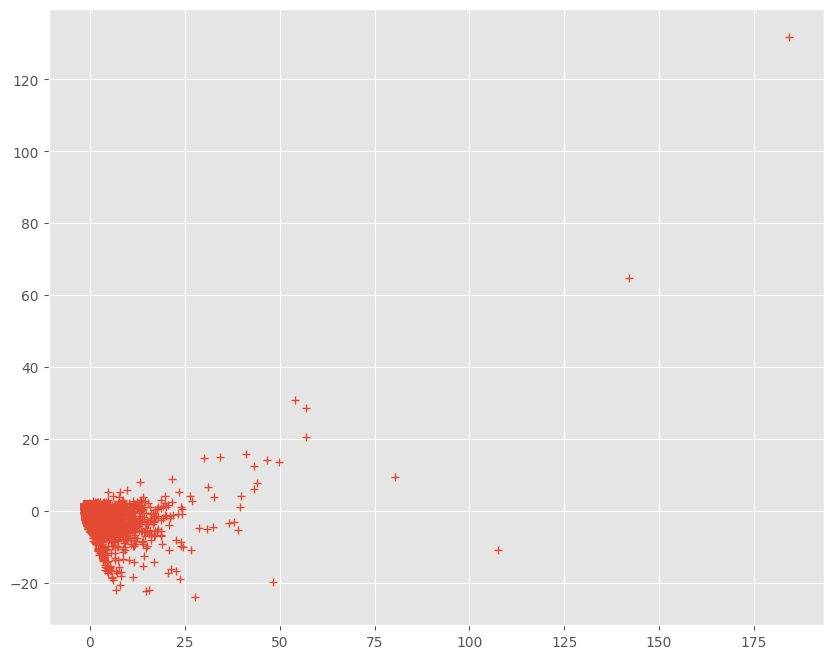

In [12]:
plt.figure(figsize=(10,8))
plt.plot(principalDf.iloc[:,0], principalDf.iloc[:,1], '+')
#plt.plot(df.index, feature_2, 'g+')

In [13]:
n_dim = len(principalDf.columns)

## Split train test 

In [15]:
# Split dataset into train and test

sample_train, sample_test, label_train, label_test = train_test_split(
     principalDf, y_train, test_size=0.2, random_state=22)

# Normalize

#std_scale = StandardScaler().fit(sample_train)
#sample_train = std_scale.transform(sample_train)
#sample_test = std_scale.transform(sample_test)

# Scale for better fit within the feature map

#samples = np.append(sample_train, sample_test, axis=0)
#minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
#sample_train = minmax_scale.transform(sample_train)
#sample_test = minmax_scale.transform(sample_test)

# Select a sample for a better control of the research and wall time

train_size = 800#160
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 200 #40
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

In [16]:
# Basic parameters for hybrid model

seed = 8500
feature_dim = 2#n_dim
num_reps = 2
num_shots =256 


## Hybrid

In [22]:
# Define feature_map

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=num_reps)

# Define the backend
backend = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"), shots=num_shots, seed_simulator=seed, seed_transpiler=seed
)

# Define the kernel

kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

# Model run
svc = SVC(kernel=kernel.evaluate)
#svc.fit(sample_train, label_train)
#score = svc.score(sample_test, label_test)

#print(f"Callable kernel classification test score: {score}")

In [70]:
#result_predict = svc.predict(sample_test)

In [21]:
#print(metrics.classification_report(label_test,result_predict))

## Classical Approaches

In [23]:
from sklearn.model_selection import cross_validate
from tqdm import tqdm
def evaluate_ml_model(_models, X, y, n_fold=10, metric='precision'):
    ''' Function to evaluate a ML and QML model with a list of metrics
    
    
    '''
    results = pd.DataFrame()
    kfold = KFold(n_splits=n_fold)
    columns = []
    for name, model in tqdm(_models):
        # -------------------
        # Variables initialization 
        _df = pd.DataFrame()
        names = []
        means = []
        stds = []
        
        # -------------------
        # k-fold Cross validation
        cv_results = cross_validate(model, X, y, cv=kfold, scoring=metric)
        
        # -------------------
        # Compute the mean and standard deviation 
        for _name, _array in cv_results.items():
            names.append(_name)
            means.append(round(100*_array.mean(), 2))
            stds.append(round(100*_array.std(), 2))
        # -------------------
        # Save the results in a dataframe 
        _df =  pd.DataFrame([means, stds], columns=names)
        columns.extend([name+' mean (%)', name+' std (%)'])
        #results = results.join(_df, on=_df.index)
        results = results.append(_df)
    results.index = columns
    print(results)
    return results

In [57]:
models = []
models.append(('LR', LogisticRegression(max_iter=1000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('qsvc', svc))
_metrics = ['precision', 'recall', 'f1', 'accuracy',  'matthews_corrcoef','balanced_accuracy']

In [58]:
df_results = pd.DataFrame()

In [59]:
df_results = evaluate_ml_model(models, sample_train, label_train, n_fold=10, metric=_metrics)

100%|██████████████████████████████████████████| 6/6 [1:22:57<00:00, 829.51s/it]

               fit_time  score_time  test_precision  test_recall  test_f1  \
LR mean (%)        0.10        0.12           94.46        25.78    39.23   
LR std (%)         0.02        0.01            9.60         9.51    11.89   
KNN mean (%)       0.03        0.18           74.15        54.84    62.38   
KNN std (%)        0.01        0.01           12.91        12.70    11.12   
CART mean (%)      0.08        0.10           53.58        55.96    54.39   
CART std (%)       0.00        0.00            9.77         8.52     8.09   
NB mean (%)        0.02        0.10           84.67         8.84    15.62   
NB std (%)         0.00        0.00           20.40         3.88     6.02   
SVM mean (%)       0.36        0.20           95.63        31.57    46.16   
SVM std (%)        0.01        0.00            5.53        11.19    11.78   
qsvc mean (%)  39213.39    10555.59            0.00         0.00     0.00   
qsvc std (%)   51778.05    17058.05            0.00         0.00     0.00   

In [60]:
df_results

,fit_time,score_time,test_precision,test_recall,test_f1,test_accuracy,test_matthews_corrcoef,test_balanced_accuracy
LR mean (%),0.10,0.12,94.46,25.78,39.23,80.50,42.05,62.46
LR std (%),0.02,0.01,9.60,9.51,11.89,3.84,8.85,4.50
KNN mean (%),0.03,0.18,74.15,54.84,62.38,84.00,53.93,74.25
KNN std (%),0.01,0.01,12.91,12.70,11.12,2.36,11.73,6.16
CART mean (%),0.08,0.10,53.58,55.96,54.39,76.38,38.72,69.60
CART std (%),0.00,0.00,9.77,8.52,8.09,4.52,10.49,5.19
NB mean (%),0.02,0.10,84.67,8.84,15.62,76.25,21.38,54.00
NB std (%),0.00,0.00,20.40,3.88,6.02,3.11,6.51,1.80
SVM mean (%),0.36,0.20,95.63,31.57,46.16,82.12,47.93,65.45
SVM std (%),0.01,0.00,5.53,11.19,11.78,3.54,8.33,5.31


## QSVC

In [ ]:
# Be assure that your qiskit version is 0.4.0
# run !pip install --upgrade qiskit==0.4.0 if not 

In [39]:
%%script false --no-raise-error
# Define feature_map, optimizer and var_form

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
optimizer = COBYLA(maxiter=20, disp=True, rhobeg=1.0, tol=None)
var_form = TwoLocal(feature_dim, ['ry', 'rz'], 'cz', reps=3)


# Define the backend

backend = qiskit.Aer.get_backend('qasm_simulator')

# Define the instance

quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

# Model run
vqc = QSVC(quantum_kernel=quantum_instance)#optimizer, feature_map, var_form, training_input, test_input, datapoints[0])


result = vqc.fit(sample_train, label_train)



In [40]:
import qiskit
qiskit.__version__

'0.21.1'

In [33]:
!pip3 install --upgrade qiskit #==0.4.0

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


## Pennylane

In [35]:
from pennylane import numpy as np

In [36]:
# Angle Encoding

num_qubits = n_dim

dev = qml.device('default.qubit', wires = num_qubits)

@qml.qnode(dev)
def circuit(parameters, data):
    for i in range(num_qubits):
        qml.Hadamard(wires = i)
    
    AngleEmbedding(features = data, wires = range(num_qubits), rotation = 'Y')
    
    qml.StronglyEntanglingLayers(weights = parameters, wires = range(num_qubits))
    
    return qml.expval(qml.PauliZ(0))

In [37]:
num_layers = 5
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

#print(weights_init, bias_init)

In [44]:
sample_train = sample_train.to_numpy()

In [45]:
circuit(weights_init, sample_train[0])

tensor(-0.17351613, requires_grad=True)

In [46]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [47]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [48]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [49]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [50]:
Y = np.array(label_train * 2 - np.ones(len(label_train)),requires_grad=True)  # shift label from {0, 1} to {-1, 1}
X = np.array(sample_train, requires_grad=True)

for i in range(5):
    print("X = {}, Y = {: d}".format(list(X[i]), int(Y[i])))

X = [tensor(-0.94548587, requires_grad=True), tensor(0.23279266, requires_grad=True)], Y = -1
X = [tensor(-1.02667469, requires_grad=True), tensor(1.13575121, requires_grad=True)], Y = -1
X = [tensor(1.71589062, requires_grad=True), tensor(1.11055076, requires_grad=True)], Y = -1
X = [tensor(-0.95659575, requires_grad=True), tensor(1.0810022, requires_grad=True)], Y = -1
X = [tensor(-0.53034402, requires_grad=True), tensor(0.03297767, requires_grad=True)], Y = -1


In [51]:
opt = AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.99, eps=1e-08)
batch_size = 10

In [52]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0
ccost = 0 
for it in range(150):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    '''if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )'''
    prec = metrics.f1_score(Y, predictions, average='binary', pos_label=1)
    if  prec > abest or ((prec == abest) and (cost(weights, bias, X, Y) < ccost)):
        wbest = weights
        bbest = bias
        abest = prec
        ccost = cost(weights, bias, X, Y)
        print('New best')
    #prec = metrics.precision_score(Y, predictions, average='binary')
    print(
        "Iter: {:5d} | Cost: {:0.7f} | f1: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), prec
        )
    )
    
    

New best
Iter:     1 | Cost: 0.8261764 | f1: 0.3687500 
Iter:     2 | Cost: 0.7720342 | f1: 0.3375796 
Iter:     3 | Cost: 0.7685542 | f1: 0.2648084 
Iter:     4 | Cost: 0.7606195 | f1: 0.2578397 
Iter:     5 | Cost: 0.7963815 | f1: 0.3550914 
Iter:     6 | Cost: 0.8475418 | f1: 0.3521127 
Iter:     7 | Cost: 0.8944030 | f1: 0.3678647 
Iter:     8 | Cost: 0.9122448 | f1: 0.3618290 
Iter:     9 | Cost: 0.8603192 | f1: 0.3616558 
New best
Iter:    10 | Cost: 0.8284707 | f1: 0.3903509 
New best
Iter:    11 | Cost: 0.8152735 | f1: 0.4732510 
New best
Iter:    12 | Cost: 0.8203489 | f1: 0.5081967 
Iter:    13 | Cost: 0.7614185 | f1: 0.4759358 
Iter:    14 | Cost: 0.7202383 | f1: 0.4269006 
Iter:    15 | Cost: 0.7063740 | f1: 0.3824451 
Iter:    16 | Cost: 0.7384483 | f1: 0.3552632 
Iter:    17 | Cost: 0.7895712 | f1: 0.3146853 
Iter:    18 | Cost: 0.8341877 | f1: 0.2968198 
Iter:    19 | Cost: 0.8740326 | f1: 0.2992701 
Iter:    20 | Cost: 0.8766615 | f1: 0.3115942 
Iter:    21 | Cost: 0.85

In [53]:
Yte = np.array(label_test * 2 - np.ones(len(label_test)))
Xte = np.array(normalize(sample_test))

In [54]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

Cost: 0.632918622733196, Accuracy: 79.0%


In [55]:
print(metrics.classification_report(predictions,Yte))

              precision    recall  f1-score   support

        -1.0       0.93      0.82      0.87       174
         1.0       0.33      0.58      0.42        26

    accuracy                           0.79       200
   macro avg       0.63      0.70      0.64       200
weighted avg       0.85      0.79      0.81       200



In [56]:
print(f'''

    Precision: {round(100*metrics.precision_score(predictions,Yte),2)}%
    Recall: {round(100*metrics.recall_score(predictions,Yte),2)}%
    f1: {round(100*metrics.f1_score(predictions,Yte),2)}%
    Accuracy: {round(100*metrics.accuracy_score(predictions,Yte),2)}%
    Balanced accuracy: {round(100*metrics.balanced_accuracy_score(predictions,Yte),2)}%
    Matthew corcorref: {round(100*metrics.matthews_corrcoef(predictions,Yte),2)}%
    ''')



    Precision: 32.61%
    Recall: 57.69%
    f1: 41.67%
    Accuracy: 79.0%
    Balanced accuracy: 69.94%
    Matthew corcorref: 31.87%
    
